## Purpose

---

This file is to automagically calculate outputs so we can validate the system output.

Using many points.


In [1]:
from gps_coordinate import GPSPoint
from math import atan2
import numpy as np

Made using [mapcustomizer](https://www.mapcustomizer.com/#)

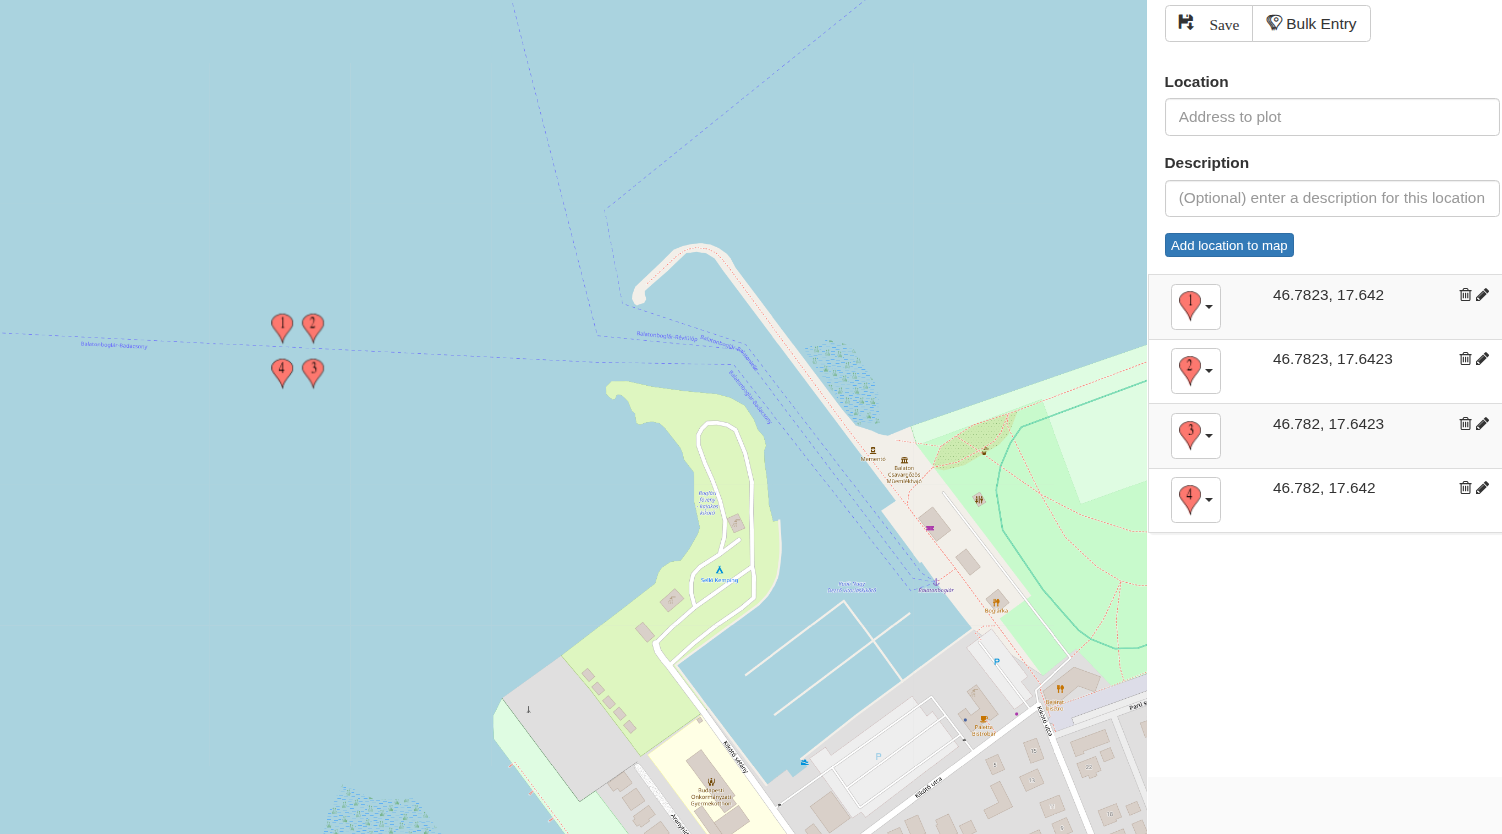


In [2]:
# Rectangle corners (latitude, longitude) - roughly 30x20 meter box
W = 17.6420
E = 17.6423
S = 46.7820
N = 46.7823

corner_1 = GPSPoint(N, W)  # bottom-left
corner_2 = GPSPoint(N, E)  # bottom-right
corner_3 = GPSPoint(S, E)  # top-right
corner_4 = GPSPoint(S, W)  # top-left

# Ordered loop of waypoints
waypoints = [corner_1, corner_2, corner_3, corner_4, corner_1]
waypoints

2025-05-27 16:41:26.439 | DEBUG    | gps_coordinate.base:__init__:52 - Initialized GPSPoint: (46.7823, 17.642)
2025-05-27 16:41:26.440 | DEBUG    | gps_coordinate.base:__init__:52 - Initialized GPSPoint: (46.7823, 17.6423)
2025-05-27 16:41:26.440 | DEBUG    | gps_coordinate.base:__init__:52 - Initialized GPSPoint: (46.782, 17.6423)
2025-05-27 16:41:26.440 | DEBUG    | gps_coordinate.base:__init__:52 - Initialized GPSPoint: (46.782, 17.642)


[GPSPoint(lat=46.7823, lon=17.642),
 GPSPoint(lat=46.7823, lon=17.6423),
 GPSPoint(lat=46.782, lon=17.6423),
 GPSPoint(lat=46.782, lon=17.642),
 GPSPoint(lat=46.7823, lon=17.642)]

In [ ]:
# Cell 1: Imports and Setup

# Sample lat/lon data
psi_deg = -45.0

# Current position (just east of WP1, close to the line WP1 → WP2)
lat_current = 46.7825
lon_current = 17.6427

# WP1: South-west point
lat_1 = 46.7822
lon_1 = 17.6425

# WP2: North-west point
lat_2 = 46.7828
lon_2 = 17.6425


# Convert heading
psi_current = np.deg2rad(psi_deg)

In [4]:
# Controller constants
k1, k2, k3, k4 = 1.6, 19.92, 2.125, 92.1
U = 1.1  # [m/s]
engine_rpm = 440

In [ ]:
def heading_to_next_waypoint(x0, y0, x1, y1):
    """Eq. (4): Heading from point 0 to point 1"""
    return atan2(y1 - y0, x1 - x0)


def cross_track_error(x, y, x_ref, y_ref, psi_k):
    return (x - x_ref) * np.sin(psi_k) - (y - y_ref) * np.cos(psi_k)


def control_output(e_psi, de_psi, e_y, int_e_y):
    delta_PD = k1 * e_psi + k2 * de_psi
    delta_PI = k3 * e_y + k4 * int_e_y

    # print(f"delta_PD: {delta_PD}")
    # print(f"delta_PI: {delta_PI}")

    return delta_PD + delta_PI

In [6]:
# Simulate movement slightly offset from path (e.g. 2m right)
offset_east = 2.0

In [ ]:
for i in range(len(waypoints) - 1):
    wp_start = waypoints[i]
    wp_end = waypoints[i + 1]

    # Compute desired course
    psi_k = heading_to_next_waypoint(wp_start.Xn, wp_start.Yn, wp_end.Xn, wp_end.Yn)

    # Simulate a boat position slightly off-path
    boat = GPSPoint(
        (wp_start.latitude + wp_end.latitude) / 2,
        (wp_start.longitude + wp_end.longitude) / 2
    )

    # Apply manual east offset
    x_boat = boat.Xn  # + offset_east
    y_boat = boat.Yn

    # Errors
    e_psi = 0.0 - psi_k  # assuming boat is facing 0° north
    de_psi = 0.0
    e_y = cross_track_error(x_boat, y_boat, wp_start.Xn, wp_start.Yn, psi_k)
    int_e_y = 0.1 * e_y

    # Rudder command
    rudder_cmd = control_output(e_psi, de_psi, e_y, int_e_y)
    rudder_cmd = np.clip(rudder_cmd, -3500, 3500)  # assume output is already in degrees

    print(f"[{i}] Rudder: {rudder_cmd:.2f}° | Engine: {engine_rpm} rpm | CTE: {e_y:.2f} m")

    # Optional: sleep for realism or plot step-by-step
    # sleep(0.5)

2025-05-27 16:41:26.486 | DEBUG    | gps_coordinate.base:__init__:52 - Initialized GPSPoint: (46.7823, 17.64215)
2025-05-27 16:41:26.486 | DEBUG    | gps_coordinate.base:__init__:52 - Initialized GPSPoint: (46.78215, 17.6423)
2025-05-27 16:41:26.487 | DEBUG    | gps_coordinate.base:__init__:52 - Initialized GPSPoint: (46.782, 17.64215)
2025-05-27 16:41:26.487 | DEBUG    | gps_coordinate.base:__init__:52 - Initialized GPSPoint: (46.78215, 17.642)


	delta_PD: 3.9174138059157984
	delta_PI: 0.007110723519438577
[0] Rudder: 3.92° | Engine: 440 rpm | CTE: 0.00 m
	delta_PD: 147.91722899647885
	delta_PI: 0.0005687364118229066
[1] Rudder: 147.92° | Engine: 440 rpm | CTE: 0.00 m
	delta_PD: -284.0826054413031
	delta_PI: -0.007111023704674774
[2] Rudder: -284.09° | Engine: 440 rpm | CTE: -0.00 m
	delta_PD: -140.08242063185622
	delta_PI: -0.0005687255297954822
[3] Rudder: -140.08° | Engine: 440 rpm | CTE: -0.00 m
